In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
os.chdir('..')
import virl
from matplotlib import pyplot as plt

In [2]:
env = virl.Epidemic(stochastic=False, noisy=False)
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

print(env.action_space)
print(env.observation_space)
print(observation_examples)



Discrete(4)
Box(0.0, inf, (4,), float64)
[[6.69911121e-02 9.01684654e-01 3.01429427e+00 1.28687232e+00]
 [7.50381696e-01 9.89018225e-02 2.00181818e-01 1.36400919e+00]
 [6.52932679e-01 8.57530100e-02 6.15337927e-01 6.82255418e-01]
 ...
 [1.37099713e+00 9.80472801e-02 1.88245692e-01 1.36117011e-01]
 [1.53520688e+00 9.35774558e-01 1.18393981e+00 2.29107216e-04]
 [4.54582924e-01 3.71918634e-01 5.29771570e-01 7.14922373e-01]]


In [3]:
# Let's import basic tools for defining the function and doing the gradient-based learning
import sklearn.pipeline
import sklearn.preprocessing
#from sklearn.preprocessing import PolynomialFeatures # you can try with polynomial basis if you want (It is difficult!)
from sklearn.linear_model import SGDRegressor # this defines the SGD function
from sklearn.kernel_approximation import RBFSampler # this is the RBF function transformation method




In [113]:

class LinearAprxAgent:
    def create_policy(self,func_approximator, epsilon):
        # from lab 8
        def policy_fn(state):
            """
            
            Input:
                state: a 2D array with the position and velocity
            Output:
                A,q_values: 
            """
            action_index = np.ones(self.num_of_actions, dtype=float) * epsilon / self.num_of_actions
            
            #transform to the same shape as the model was trained on
            state_transformed = self.feature_transformer.transform([state])
            q_values = self.func_approximator.predict(state_transformed)
           
            best_action = np.argmax(q_values)
            action_index[best_action] += (1.0 - epsilon)
            
            
            return action_index,q_values  # return the potentially stochastic policy (which is due to the exploration)

        return policy_fn # return a handle to the function so we can call it in the future
        
    def __init__(self,env):
        
        #RBF Hyper parameters
        SGD_learning_rate = "optimal" #‘constant’, ‘optimal’, ‘invscaling’, ‘adaptive’
        tol = 1e-5 #The stopping criterion
        SGD_max_iter = 1e4
        
        
        self.func_approximator =  SGDRegressor(learning_rate=SGD_learning_rate, tol=tol, max_iter=SGD_max_iter, loss='huber')
        self.feature_transformer =  sklearn.pipeline.FeatureUnion([
                ("rbf1", RBFSampler(gamma=12.8, n_components=50)),
                ("rbf2", RBFSampler(gamma=6.4, n_components=50)),
                ("rbf3", RBFSampler(gamma=3.2, n_components=50)),
                ("rbf4", RBFSampler(gamma=1.6, n_components=50)),
                ("rbf5", RBFSampler(gamma=0.8, n_components=50)),
                ("rbf6", RBFSampler(gamma=0.4, n_components=50)),
                ("rbf7", RBFSampler(gamma=0.2, n_components=50)),
                ("rbf8", RBFSampler(gamma=0.1, n_components=50))
                ])
        
        
        self.num_of_actions = env.action_space.n
        self.env = env
        self.policy = self.create_policy(self.func_approximator,1)
        
        self.episodes = 200
        self.print_out_every_x_episodes = int(self.episodes/50)
        self.times_exploited = 0
        
        # hyper parameters for epsilon explore
        self.initial_epsilon = 1 # initial
        self.decrease_factor = (1/self.episodes)/1.25 # epsilon
        print("Decrease Factor: " + str(self.decrease_factor))
        
        
    
    def run_all_episodes(self):
        all_total_rewards = []
        all_rewards = []
        epsilon = self.initial_epsilon # at the start only explore
        
        
        power = 1
        for episode in range(1, self.episodes + 1):
            states,rewards = self.run_episode(epsilon)
            total_reward = np.sum(rewards)
            
            
            if episode % self.print_out_every_x_episodes == 0:
                print("Episode number: " + str(episode) + ". Total reward in episode: " + str(total_reward) + ". Episode executed with epsilon = " + str(epsilon))
                print("Average total reward in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_rewards[-self.print_out_every_x_episodes:])))
                print("Times exploited the last episode " + str(self.times_exploited))
                print("-----")
            self.times_exploited = 0
            all_rewards.append(rewards)
            all_total_rewards.append(total_reward)
            epsilon = self.decrease_epsilon(epsilon, power)
            power += 0.10
        #returns all rewards and the last episodes state
        return states,all_rewards, all_total_rewards
    
    
    #exponential decrease in epsilon
    def decrease_epsilon(self, epsilon, power):
        decrease = 0.005
        return epsilon * ((1 - decrease) ** power)
    
    def run_episode(self,epsilon):
        rewards = []
        states = []
        actions = []
        done = False
        
        state = self.env.reset()
        states.append(state)
        
      
        
        while not done:
            random_number = np.random.random()
            if random_number < epsilon:
                #explore
                action = np.random.choice(self.num_of_actions)
                
            else:
                #exploit
                action = self.get_action(state)
                self.times_exploited += 1
              
            
            new_state, reward, done, i = self.env.step(action=action)
            
            states.append(new_state)
            actions.append(action)    
            rewards.append(reward)
            
            #update policy function
            self.update(states[1:],rewards, epsilon)
        
            
            state = new_state
        return states,rewards
        
    def update(self,states,rewards, epsilon):
        
        #update the linear function
        self.feature_transformer.fit(states)
        states_transformed = self.feature_transformer.transform(states)
        
        
        self.func_approximator.fit(states_transformed,rewards)
        self.policy = self.create_policy(self.func_approximator,epsilon)
                                                       
        
    def get_action(self,state):
        #linear function to get best action
        actions,q_values = self.policy(state)
        return np.argmax(actions)
    
    def get_action_text(self):
        return action_text
    
    def get_env(self):
        return env
    
    def get_chart_title(self):
        return "Action = " + action_text

In [114]:

env = virl.Epidemic(stochastic=False, noisy=False)
agent = LinearAprxAgent(env)
states,all_rewards, all_total_rewards = agent.run_all_episodes()



Decrease Factor: 0.004
Episode number: 4. Total reward in episode: -1.7295100308687366. Episode executed with epsilon = 0.98359466951464
Average total reward in last 4 episodes: -0.0325013783548486
Times exploited the last episode 4
-----
Episode number: 8. Total reward in episode: -2.1252075379221242. Episode executed with epsilon = 0.9554105547748558
Average total reward in last 4 episodes: -0.03139335930990204
Times exploited the last episode 2
-----
Episode number: 12. Total reward in episode: -1.6497257320439456. Episode executed with epsilon = 0.920620904771527
Average total reward in last 4 episodes: -0.03799602115914395
Times exploited the last episode 4
-----
Episode number: 16. Total reward in episode: -2.010567145375957. Episode executed with epsilon = 0.8800119284892101
Average total reward in last 4 episodes: -0.032723899970057736
Times exploited the last episode 4
-----
Episode number: 20. Total reward in episode: -1.5017075317172053. Episode executed with epsilon = 0.834

Episode number: 152. Total reward in episode: -1.6811867446144855. Episode executed with epsilon = 0.0016066605759151868
Average total reward in last 4 episodes: -0.03233051431950933
Times exploited the last episode 52
-----
Episode number: 156. Total reward in episode: -1.6811867446144855. Episode executed with epsilon = 0.0011599102482570333
Average total reward in last 4 episodes: -0.03233051431950933
Times exploited the last episode 52
-----
Episode number: 160. Total reward in episode: -1.6811867446144855. Episode executed with epsilon = 0.0008306949365847114
Average total reward in last 4 episodes: -0.03233051431950933
Times exploited the last episode 52
-----
Episode number: 164. Total reward in episode: -1.6811867446144855. Episode executed with epsilon = 0.0005901680170977277
Average total reward in last 4 episodes: -0.03233051431950933
Times exploited the last episode 52
-----
Episode number: 168. Total reward in episode: -1.6811867446144855. Episode executed with epsilon = 0

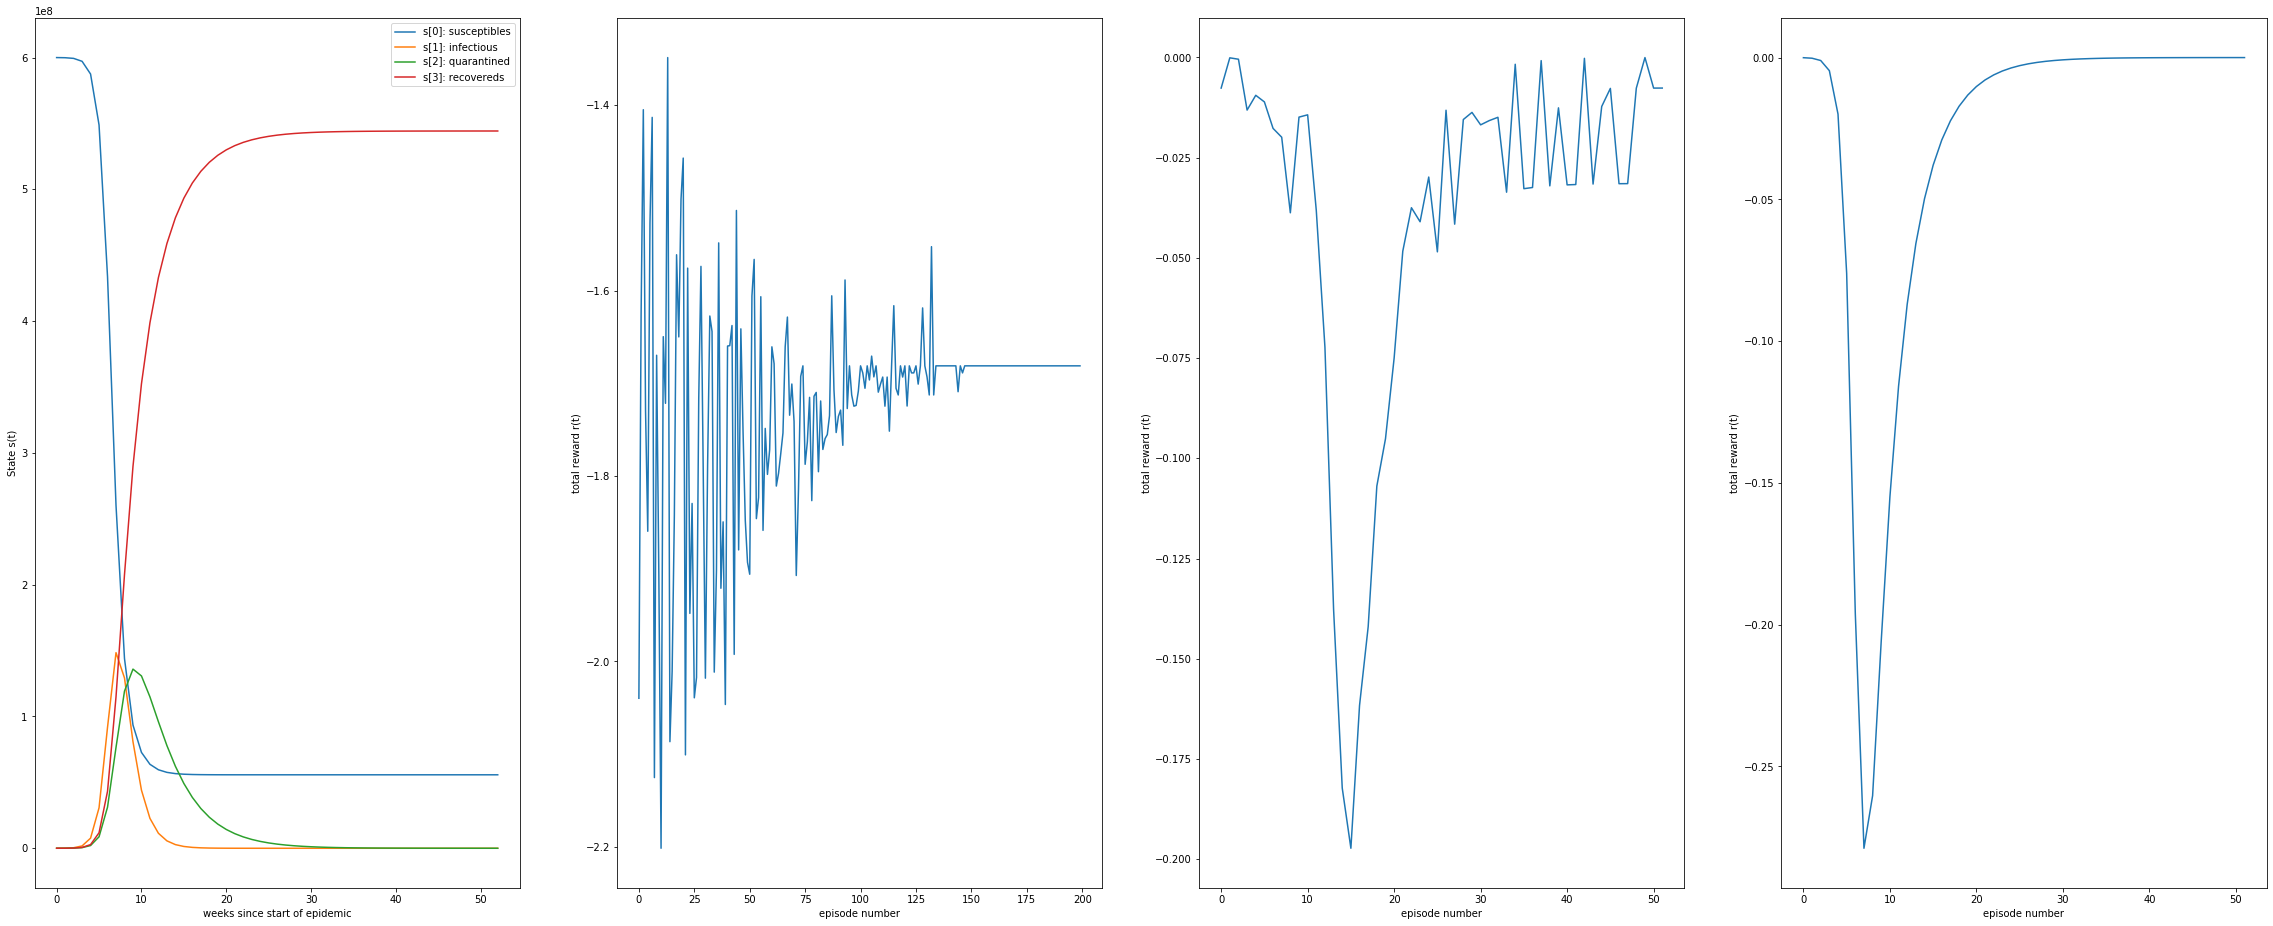

In [122]:

def plot(state,agent, total_rewards, rewards):
    fig, axes = plt.subplots(1, 4, figsize=(40, 16))
    labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
    states = np.array(state)
    for i in range(4):
        axes[0].plot(states[:,i], label=labels[i]);
    axes[0].set_xlabel('weeks since start of epidemic')
    axes[0].set_ylabel('State s(t)')
    axes[0].legend()
    
    axes[1].plot(total_rewards);
    axes[1].set_xlabel('episode number')
    axes[1].set_ylabel('total reward r(t)')

    axes[2].plot(rewards[0]);
    axes[2].set_xlabel('episode number')
    axes[2].set_ylabel('total reward r(t)')
    
    axes[3].plot(rewards[-1]);
    axes[3].set_xlabel('episode number')
    axes[3].set_ylabel('total reward r(t)')
    
plot(states,agent, all_total_rewards, all_rewards)
##print(all_rewards)



In [124]:
total_reward_sd = np.std(all_total_rewards)
total_reward_mean = np.mean(all_total_rewards)
reward_sd = np.std(all_rewards)
reward_mean = np.mean(all_rewards)

print("Total reward standard deviation = " + str(total_reward_sd))
print("Total reward mean = " + str(total_reward_mean))
print("Reward standard deviation = " + str(reward_sd))
print("Rotal reward mean = " + str(reward_mean))

Total reward standard deviation = 0.1194487349058369
Total reward mean = -1.7194870765081018
Reward standard deviation = 0.06120590042529747
Rotal reward mean = -0.033067059163617345


In [129]:
print("---------------------")
print("|      o  o          |")
print("|     \____/         |")
print("|       ||           |")
print("|<------||------>    |")
print("|       ||           |")
print("|     __||__         |")
print("|    /      \        |")
print("|   /        \       |")
print("|  /          \      |")
print("---------------------")


print("Hello, I am Perry")

---------------------
|      o  o          |
|     \____/         |
|       ||           |
|<------||------>    |
|       ||           |
|     __||__         |
|    /      \        |
|   /        \       |
|  /          \      |
---------------------
Hello, I am Perry
